In [1]:
import pandas as pd
import string
import matplotlib.pyplot as plt
import math
import tensorflow as tf
import numpy as np
from tensorflow.keras import datasets, layers, models
import tensorflow.keras
from sklearn.model_selection import train_test_split, KFold
from sklearn import preprocessing
import matplotlib.pyplot as plt
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import classification_report, confusion_matrix

2023-03-13 10:47:37.500866: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-03-13 10:47:37.500948: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
allData = pd.read_csv('../feature_data/features.csv')
allData.replace([np.inf, -np.inf], np.nan, inplace=True)
allData = allData.dropna()
X = allData.drop(["label"],axis=1)
X = X.drop(["radius"],axis=1)
cols = X.keys()

#normalize data
#X = preprocessing.normalize(X, norm='max')

#labels
y = allData["label"]

#features
X = pd.DataFrame(X, columns = cols)

In [3]:
X.describe()

,num_points,std,avg_median_dev,width,linearity,circularity,boundary_length,boundary_regularity,mean_curvature,ang_diff,iav,std_iav,distance,dist_num_points,occluded_right,occluded_left
count,9489.000000,9489.000000,9489.000000,9489.000000,9489.000000,9.489000e+03,9489.000000,9489.000000,9489.000000,9489.000000,9489.000000,9489.000000,9489.000000,9489.000000,9489.000000,9489.000000
mean,17.307936,0.145534,0.123339,0.442383,19.646191,1.498107e-01,0.534513,0.017417,19.784566,2.237601,2.627493,1.561736,2.957513,0.440747,0.783644,0.722942
std,27.506733,0.233990,0.205220,0.791545,158.022617,1.136570e+00,0.933008,0.012034,18.819969,0.623728,0.718840,0.519241,1.900385,0.528611,0.411781,0.447569
min,3.000000,0.008048,0.005680,0.012648,0.000076,8.969470e-16,0.017039,0.002987,0.045276,0.186256,0.421913,0.273109,0.289371,0.002502,0.000000,0.000000
25%,6.000000,0.038555,0.031740,0.101891,0.006914,1.677530e-04,0.130319,0.008200,5.679890,1.890190,2.219300,1.202750,1.478220,0.101666,1.000000,0.000000
50%,9.000000,0.056707,0.045411,0.144635,0.025590,8.454680e-04,0.195660,0.013237,13.218500,2.376490,2.777150,1.578390,2.345690,0.244998,1.000000,1.000000
75%,17.000000,0.134151,0.118170,0.380985,0.823912,5.842730e-03,0.525086,0.024435,28.153900,2.733730,3.127850,1.915240,4.034960,0.561094,1.000000,1.000000
max,279.000000,3.033200,2.481590,12.762600,3971.650000,2.965000e+01,12.889000,0.072851,123.093000,3.127740,4.565440,3.304990,7.458060,2.482980,1.000000,1.000000


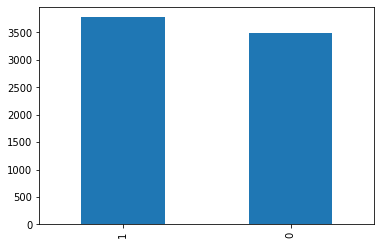

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=5)
    
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.15, random_state=5)
y_train.value_counts().plot.bar()


#oversample the minority
y_train.value_counts().plot.bar()

ros = RandomOverSampler(sampling_strategy="minority", random_state=5)
#X_train, y_train = ros.fit_resample(X_train, y_train)

#y_train.value_counts().plot.bar()
#y_test.value_counts().plot.bar()

In [5]:
def CNN_Model(units = 32, dropout=0.2, optimizer = 'adam'):
    model = models.Sequential()
    model.add(tensorflow.keras.Input(shape=(16,)))
    model.add(tf.keras.layers.BatchNormalization())

    model.add(layers.Dense(units = units, activation='leaky_relu',))

    model.add(layers.Dense(units = units, activation='leaky_relu',))
    
    model.add(layers.Dense(units = units, activation='leaky_relu'))

    model.add(layers.Dense(units = units, activation='leaky_relu'))

    model.add(layers.Dense(1, activation='sigmoid'))
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                  loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
                  metrics=['accuracy'])
    return model
    

In [6]:
ms = []
hs = []
for f in [32,64,96,128,190]:
    #for d in [0.15,0.2,0.25,0.3]:
    #    if (f == 32 and d == 0.2) or (f==64 and d==0.15) or (f==96 and d!=0.2):
    model = CNN_Model(units=f)
    model.summary()
    ms.append(model)
    history = model.fit(X_train, y_train, epochs=150, 
                    validation_data=(X_val, y_val))
    hs.append(history)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (BatchN  (None, 16)               64        
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 32)                544       
                                                                 
 dense_1 (Dense)             (None, 32)                1056      
                                                                 
 dense_2 (Dense)             (None, 32)                1056      
                                                                 
 dense_3 (Dense)             (None, 32)                1056      
                                                                 
 dense_4 (Dense)             (None, 1)                 33        
                                                        

2023-03-13 10:47:51.923380: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2023-03-13 10:47:51.923433: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (pedrod33): /proc/driver/nvidia/version does not exist
2023-03-13 10:47:51.924944: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/150
227/227 [==============================] - 2s 4ms/step - loss: 0.2303 - accuracy: 0.9124 - val_loss: 0.1354 - val_accuracy: 0.9477
Epoch 2/150
227/227 [==============================] - 1s 2ms/step - loss: 0.1466 - accuracy: 0.9328 - val_loss: 0.1208 - val_accuracy: 0.9500
Epoch 3/150
227/227 [==============================] - 1s 2ms/step - loss: 0.1338 - accuracy: 0.9413 - val_loss: 0.1170 - val_accuracy: 0.9508
Epoch 4/150
227/227 [==============================] - 1s 2ms/step - loss: 0.1342 - accuracy: 0.9431 - val_loss: 0.1042 - val_accuracy: 0.9578
Epoch 5/150
227/227 [==============================] - 1s 2ms/step - loss: 0.1283 - accuracy: 0.9435 - val_loss: 0.1078 - val_accuracy: 0.9547
Epoch 6/150
227/227 [==============================] - 1s 2ms/step - loss: 0.1224 - accuracy: 0.9452 - val_loss: 0.1003 - val_accuracy: 0.9633
Epoch 7/150
227/227 [==============================] - 1s 2ms/step - loss: 0.1216 - accuracy: 0.9471 - val_loss: 0.1000 - val_accuracy: 0.9602

Epoch 58/150
227/227 [==============================] - 1s 2ms/step - loss: 0.0942 - accuracy: 0.9617 - val_loss: 0.0965 - val_accuracy: 0.9680
Epoch 59/150
227/227 [==============================] - 1s 2ms/step - loss: 0.0958 - accuracy: 0.9620 - val_loss: 0.0876 - val_accuracy: 0.9672
Epoch 60/150
227/227 [==============================] - 1s 2ms/step - loss: 0.0987 - accuracy: 0.9584 - val_loss: 0.0929 - val_accuracy: 0.9657
Epoch 61/150
227/227 [==============================] - 1s 2ms/step - loss: 0.0960 - accuracy: 0.9614 - val_loss: 0.0911 - val_accuracy: 0.9649
Epoch 62/150
227/227 [==============================] - 1s 2ms/step - loss: 0.0936 - accuracy: 0.9606 - val_loss: 0.0918 - val_accuracy: 0.9664
Epoch 63/150
227/227 [==============================] - 1s 2ms/step - loss: 0.0939 - accuracy: 0.9599 - val_loss: 0.0942 - val_accuracy: 0.9586
Epoch 64/150
227/227 [==============================] - 1s 2ms/step - loss: 0.0960 - accuracy: 0.9614 - val_loss: 0.0891 - val_accuracy:

Epoch 115/150
227/227 [==============================] - 1s 2ms/step - loss: 0.0888 - accuracy: 0.9650 - val_loss: 0.0914 - val_accuracy: 0.9672
Epoch 116/150
227/227 [==============================] - 1s 2ms/step - loss: 0.0841 - accuracy: 0.9636 - val_loss: 0.0943 - val_accuracy: 0.9703
Epoch 117/150
227/227 [==============================] - 1s 3ms/step - loss: 0.0866 - accuracy: 0.9656 - val_loss: 0.0861 - val_accuracy: 0.9711
Epoch 118/150
227/227 [==============================] - 1s 2ms/step - loss: 0.0862 - accuracy: 0.9634 - val_loss: 0.0887 - val_accuracy: 0.9711
Epoch 119/150
227/227 [==============================] - 1s 2ms/step - loss: 0.0870 - accuracy: 0.9651 - val_loss: 0.0891 - val_accuracy: 0.9688
Epoch 120/150
227/227 [==============================] - 1s 2ms/step - loss: 0.0865 - accuracy: 0.9658 - val_loss: 0.0865 - val_accuracy: 0.9696
Epoch 121/150
227/227 [==============================] - 1s 2ms/step - loss: 0.0862 - accuracy: 0.9645 - val_loss: 0.0940 - val_ac

Epoch 13/150
227/227 [==============================] - 1s 3ms/step - loss: 0.1108 - accuracy: 0.9539 - val_loss: 0.0962 - val_accuracy: 0.9649
Epoch 14/150
227/227 [==============================] - 1s 3ms/step - loss: 0.1116 - accuracy: 0.9534 - val_loss: 0.1010 - val_accuracy: 0.9602
Epoch 15/150
227/227 [==============================] - 1s 3ms/step - loss: 0.1150 - accuracy: 0.9550 - val_loss: 0.0994 - val_accuracy: 0.9657
Epoch 16/150
227/227 [==============================] - 1s 2ms/step - loss: 0.1132 - accuracy: 0.9534 - val_loss: 0.0978 - val_accuracy: 0.9657
Epoch 17/150
227/227 [==============================] - 1s 3ms/step - loss: 0.1066 - accuracy: 0.9548 - val_loss: 0.1001 - val_accuracy: 0.9617
Epoch 18/150
227/227 [==============================] - 1s 3ms/step - loss: 0.1060 - accuracy: 0.9555 - val_loss: 0.1114 - val_accuracy: 0.9571
Epoch 19/150
227/227 [==============================] - 1s 2ms/step - loss: 0.1073 - accuracy: 0.9527 - val_loss: 0.0965 - val_accuracy:

Epoch 70/150
227/227 [==============================] - 1s 2ms/step - loss: 0.0896 - accuracy: 0.9646 - val_loss: 0.0910 - val_accuracy: 0.9688
Epoch 71/150
227/227 [==============================] - 1s 2ms/step - loss: 0.0832 - accuracy: 0.9660 - val_loss: 0.0895 - val_accuracy: 0.9688
Epoch 72/150
227/227 [==============================] - 1s 2ms/step - loss: 0.0888 - accuracy: 0.9650 - val_loss: 0.0879 - val_accuracy: 0.9657
Epoch 73/150
227/227 [==============================] - 1s 2ms/step - loss: 0.0881 - accuracy: 0.9632 - val_loss: 0.0891 - val_accuracy: 0.9703
Epoch 74/150
227/227 [==============================] - 1s 2ms/step - loss: 0.0842 - accuracy: 0.9654 - val_loss: 0.0860 - val_accuracy: 0.9680
Epoch 75/150
227/227 [==============================] - 1s 2ms/step - loss: 0.0830 - accuracy: 0.9638 - val_loss: 0.0874 - val_accuracy: 0.9696
Epoch 76/150
227/227 [==============================] - 1s 2ms/step - loss: 0.0891 - accuracy: 0.9642 - val_loss: 0.0983 - val_accuracy:

Epoch 127/150
227/227 [==============================] - 0s 2ms/step - loss: 0.0811 - accuracy: 0.9664 - val_loss: 0.1052 - val_accuracy: 0.9641
Epoch 128/150
227/227 [==============================] - 1s 2ms/step - loss: 0.0805 - accuracy: 0.9671 - val_loss: 0.0951 - val_accuracy: 0.9680
Epoch 129/150
227/227 [==============================] - 1s 2ms/step - loss: 0.0773 - accuracy: 0.9707 - val_loss: 0.0980 - val_accuracy: 0.9688
Epoch 130/150
227/227 [==============================] - 0s 2ms/step - loss: 0.0762 - accuracy: 0.9691 - val_loss: 0.0881 - val_accuracy: 0.9703
Epoch 131/150
227/227 [==============================] - 1s 2ms/step - loss: 0.0706 - accuracy: 0.9733 - val_loss: 0.0865 - val_accuracy: 0.9688
Epoch 132/150
227/227 [==============================] - 0s 2ms/step - loss: 0.0812 - accuracy: 0.9654 - val_loss: 0.1064 - val_accuracy: 0.9657
Epoch 133/150
227/227 [==============================] - 0s 2ms/step - loss: 0.0796 - accuracy: 0.9676 - val_loss: 0.1040 - val_ac

Epoch 25/150
227/227 [==============================] - 1s 2ms/step - loss: 0.0997 - accuracy: 0.9600 - val_loss: 0.0975 - val_accuracy: 0.9610
Epoch 26/150
227/227 [==============================] - 1s 2ms/step - loss: 0.1006 - accuracy: 0.9584 - val_loss: 0.0988 - val_accuracy: 0.9586
Epoch 27/150
227/227 [==============================] - 1s 2ms/step - loss: 0.1064 - accuracy: 0.9585 - val_loss: 0.0898 - val_accuracy: 0.9649
Epoch 28/150
227/227 [==============================] - 1s 2ms/step - loss: 0.1000 - accuracy: 0.9606 - val_loss: 0.0924 - val_accuracy: 0.9672
Epoch 29/150
227/227 [==============================] - 1s 2ms/step - loss: 0.1052 - accuracy: 0.9578 - val_loss: 0.0850 - val_accuracy: 0.9672
Epoch 30/150
227/227 [==============================] - 1s 2ms/step - loss: 0.0960 - accuracy: 0.9618 - val_loss: 0.0895 - val_accuracy: 0.9649
Epoch 31/150
227/227 [==============================] - 1s 2ms/step - loss: 0.0927 - accuracy: 0.9623 - val_loss: 0.0932 - val_accuracy:

Epoch 82/150
227/227 [==============================] - 1s 2ms/step - loss: 0.0848 - accuracy: 0.9682 - val_loss: 0.0849 - val_accuracy: 0.9664
Epoch 83/150
227/227 [==============================] - 1s 2ms/step - loss: 0.0801 - accuracy: 0.9669 - val_loss: 0.0850 - val_accuracy: 0.9672
Epoch 84/150
227/227 [==============================] - 1s 2ms/step - loss: 0.0848 - accuracy: 0.9657 - val_loss: 0.0862 - val_accuracy: 0.9703
Epoch 85/150
227/227 [==============================] - 1s 2ms/step - loss: 0.0816 - accuracy: 0.9656 - val_loss: 0.0960 - val_accuracy: 0.9664
Epoch 86/150
227/227 [==============================] - 1s 2ms/step - loss: 0.0858 - accuracy: 0.9662 - val_loss: 0.0873 - val_accuracy: 0.9696
Epoch 87/150
227/227 [==============================] - 1s 2ms/step - loss: 0.0810 - accuracy: 0.9672 - val_loss: 0.0829 - val_accuracy: 0.9696
Epoch 88/150
227/227 [==============================] - 1s 2ms/step - loss: 0.0841 - accuracy: 0.9660 - val_loss: 0.0860 - val_accuracy:

227/227 [==============================] - 1s 3ms/step - loss: 0.0750 - accuracy: 0.9685 - val_loss: 0.0944 - val_accuracy: 0.9625
Epoch 139/150
227/227 [==============================] - 1s 2ms/step - loss: 0.0728 - accuracy: 0.9720 - val_loss: 0.0849 - val_accuracy: 0.9703
Epoch 140/150
227/227 [==============================] - 1s 2ms/step - loss: 0.0782 - accuracy: 0.9690 - val_loss: 0.0968 - val_accuracy: 0.9688
Epoch 141/150
227/227 [==============================] - 1s 3ms/step - loss: 0.0762 - accuracy: 0.9690 - val_loss: 0.0879 - val_accuracy: 0.9727
Epoch 142/150
227/227 [==============================] - 1s 2ms/step - loss: 0.0738 - accuracy: 0.9705 - val_loss: 0.0883 - val_accuracy: 0.9688
Epoch 143/150
227/227 [==============================] - 1s 2ms/step - loss: 0.0749 - accuracy: 0.9709 - val_loss: 0.0856 - val_accuracy: 0.9672
Epoch 144/150
227/227 [==============================] - 1s 2ms/step - loss: 0.0721 - accuracy: 0.9694 - val_loss: 0.0952 - val_accuracy: 0.9664

227/227 [==============================] - 1s 2ms/step - loss: 0.0970 - accuracy: 0.9592 - val_loss: 0.0905 - val_accuracy: 0.9703
Epoch 37/150
227/227 [==============================] - 1s 2ms/step - loss: 0.1004 - accuracy: 0.9594 - val_loss: 0.0904 - val_accuracy: 0.9711
Epoch 38/150
227/227 [==============================] - 1s 2ms/step - loss: 0.0968 - accuracy: 0.9592 - val_loss: 0.0877 - val_accuracy: 0.9696
Epoch 39/150
227/227 [==============================] - 1s 2ms/step - loss: 0.1009 - accuracy: 0.9589 - val_loss: 0.0868 - val_accuracy: 0.9680
Epoch 40/150
227/227 [==============================] - 1s 2ms/step - loss: 0.0949 - accuracy: 0.9629 - val_loss: 0.0867 - val_accuracy: 0.9696
Epoch 41/150
227/227 [==============================] - 1s 2ms/step - loss: 0.0934 - accuracy: 0.9627 - val_loss: 0.0902 - val_accuracy: 0.9664
Epoch 42/150
227/227 [==============================] - 1s 2ms/step - loss: 0.0939 - accuracy: 0.9656 - val_loss: 0.0987 - val_accuracy: 0.9649
Epoch

Epoch 93/150
227/227 [==============================] - 1s 3ms/step - loss: 0.0806 - accuracy: 0.9687 - val_loss: 0.0823 - val_accuracy: 0.9735
Epoch 94/150
227/227 [==============================] - 1s 3ms/step - loss: 0.0842 - accuracy: 0.9660 - val_loss: 0.0959 - val_accuracy: 0.9680
Epoch 95/150
227/227 [==============================] - 1s 3ms/step - loss: 0.0857 - accuracy: 0.9660 - val_loss: 0.0853 - val_accuracy: 0.9688
Epoch 96/150
227/227 [==============================] - 1s 3ms/step - loss: 0.0857 - accuracy: 0.9654 - val_loss: 0.0897 - val_accuracy: 0.9680
Epoch 97/150
227/227 [==============================] - 1s 3ms/step - loss: 0.0800 - accuracy: 0.9682 - val_loss: 0.0888 - val_accuracy: 0.9664
Epoch 98/150
227/227 [==============================] - 1s 3ms/step - loss: 0.0802 - accuracy: 0.9686 - val_loss: 0.0894 - val_accuracy: 0.9672
Epoch 99/150
227/227 [==============================] - 1s 3ms/step - loss: 0.0889 - accuracy: 0.9642 - val_loss: 0.0929 - val_accuracy:

227/227 [==============================] - 1s 3ms/step - loss: 0.0757 - accuracy: 0.9691 - val_loss: 0.1024 - val_accuracy: 0.9649
Epoch 150/150
227/227 [==============================] - 1s 3ms/step - loss: 0.0694 - accuracy: 0.9716 - val_loss: 0.0967 - val_accuracy: 0.9657
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization_4 (Batc  (None, 16)               64        
 hNormalization)                                                 
                                                                 
 dense_20 (Dense)            (None, 190)               3230      
                                                                 
 dense_21 (Dense)            (None, 190)               36290     
                                                                 
 dense_22 (Dense)            (None, 190)               36290     
                                          

227/227 [==============================] - 1s 3ms/step - loss: 0.0910 - accuracy: 0.9632 - val_loss: 0.0926 - val_accuracy: 0.9657
Epoch 48/150
227/227 [==============================] - 1s 3ms/step - loss: 0.0924 - accuracy: 0.9635 - val_loss: 0.0882 - val_accuracy: 0.9680
Epoch 49/150
227/227 [==============================] - 1s 3ms/step - loss: 0.0961 - accuracy: 0.9624 - val_loss: 0.0889 - val_accuracy: 0.9719
Epoch 50/150
227/227 [==============================] - 1s 3ms/step - loss: 0.0929 - accuracy: 0.9639 - val_loss: 0.0913 - val_accuracy: 0.9664
Epoch 51/150
227/227 [==============================] - 1s 3ms/step - loss: 0.0950 - accuracy: 0.9606 - val_loss: 0.0956 - val_accuracy: 0.9657
Epoch 52/150
227/227 [==============================] - 1s 3ms/step - loss: 0.0906 - accuracy: 0.9639 - val_loss: 0.0897 - val_accuracy: 0.9680
Epoch 53/150
227/227 [==============================] - 1s 3ms/step - loss: 0.0940 - accuracy: 0.9629 - val_loss: 0.0893 - val_accuracy: 0.9703
Epoch

Epoch 104/150
227/227 [==============================] - 1s 3ms/step - loss: 0.0778 - accuracy: 0.9672 - val_loss: 0.0883 - val_accuracy: 0.9672
Epoch 105/150
227/227 [==============================] - 1s 3ms/step - loss: 0.0809 - accuracy: 0.9676 - val_loss: 0.0935 - val_accuracy: 0.9657
Epoch 106/150
227/227 [==============================] - 1s 3ms/step - loss: 0.0796 - accuracy: 0.9674 - val_loss: 0.0944 - val_accuracy: 0.9680
Epoch 107/150
227/227 [==============================] - 1s 3ms/step - loss: 0.0825 - accuracy: 0.9683 - val_loss: 0.0893 - val_accuracy: 0.9711
Epoch 108/150
227/227 [==============================] - 1s 3ms/step - loss: 0.0779 - accuracy: 0.9705 - val_loss: 0.0828 - val_accuracy: 0.9696
Epoch 109/150
227/227 [==============================] - 1s 3ms/step - loss: 0.0776 - accuracy: 0.9705 - val_loss: 0.0924 - val_accuracy: 0.9657
Epoch 110/150
227/227 [==============================] - 1s 3ms/step - loss: 0.0772 - accuracy: 0.9679 - val_loss: 0.0964 - val_ac

30/30 - 0s - loss: 0.0905 - accuracy: 0.9631 - 57ms/epoch - 2ms/step
Test Loss: 0.09047538787126541
Test Accuracy: 0.9631190896034241


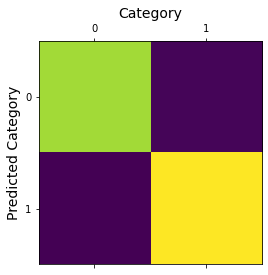

              precision    recall  f1-score   support

           0       0.95      0.97      0.96       438
           1       0.97      0.96      0.97       511

    accuracy                           0.96       949
   macro avg       0.96      0.96      0.96       949
weighted avg       0.96      0.96      0.96       949

30/30 - 0s - loss: 0.1143 - accuracy: 0.9663 - 47ms/epoch - 2ms/step
Test Loss: 0.11432075500488281
Test Accuracy: 0.9662802815437317


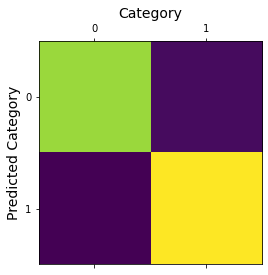

              precision    recall  f1-score   support

           0       0.95      0.98      0.96       431
           1       0.98      0.96      0.97       518

    accuracy                           0.97       949
   macro avg       0.97      0.97      0.97       949
weighted avg       0.97      0.97      0.97       949

30/30 - 0s - loss: 0.1010 - accuracy: 0.9663 - 49ms/epoch - 2ms/step
Test Loss: 0.10103453695774078
Test Accuracy: 0.9662802815437317


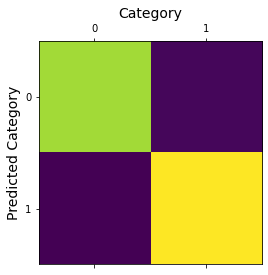

              precision    recall  f1-score   support

           0       0.96      0.97      0.96       437
           1       0.98      0.96      0.97       512

    accuracy                           0.97       949
   macro avg       0.97      0.97      0.97       949
weighted avg       0.97      0.97      0.97       949

30/30 - 0s - loss: 0.0996 - accuracy: 0.9621 - 47ms/epoch - 2ms/step
Test Loss: 0.09963752329349518
Test Accuracy: 0.9620653390884399


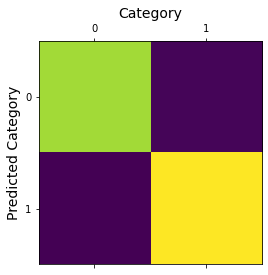

              precision    recall  f1-score   support

           0       0.95      0.97      0.96       439
           1       0.97      0.96      0.96       510

    accuracy                           0.96       949
   macro avg       0.96      0.96      0.96       949
weighted avg       0.96      0.96      0.96       949

30/30 - 0s - loss: 0.1068 - accuracy: 0.9726 - 55ms/epoch - 2ms/step
Test Loss: 0.10683070868253708
Test Accuracy: 0.9726027250289917


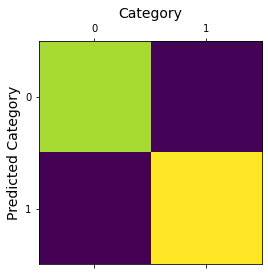

              precision    recall  f1-score   support

           0       0.97      0.98      0.97       441
           1       0.98      0.97      0.97       508

    accuracy                           0.97       949
   macro avg       0.97      0.97      0.97       949
weighted avg       0.97      0.97      0.97       949



In [7]:
for m in ms:
    test_loss, test_acc = m.evaluate(X_test,  y_test, verbose=2)
    print("Test Loss:", test_loss)
    print("Test Accuracy:", test_acc)
    y_pred = m.predict(X_test)
    a = []
    for x in y_pred:
        a.append(1 if x[0] > 0.5 else 0)
    y_pred = pd.Series(a)
    plt.matshow(confusion_matrix(y_test, y_pred, labels=[0,1]))
    plt.ylabel("Predicted Category", fontsize=14)
    plt.title("Category", fontsize=14)
    plt.show()
    print(classification_report(y_pred,y_test))

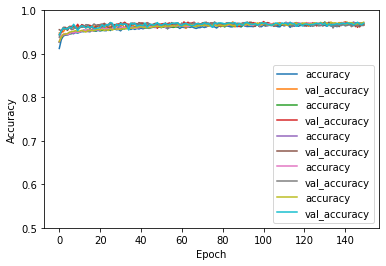

In [8]:
for i in range(len(hs)):
    plt.plot(hs[i].history['accuracy'], label='accuracy')
    plt.plot(hs[i].history['val_accuracy'], label = 'val_accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.ylim([0.5, 1])
    plt.legend(loc='lower right')
